### Descriptive and comparative analysis of IgA measures

This notebook explores different strategies to compare IgA measures using different categorical values for Attachment and Gender.

Specifically, this notebook implements:

- Reading and cleaning input data
- Remove non-relevant columns
- Plot distributions of IgA by Attachment and Gender using boxplots and violin plots
- Statistical comparison for IgA measures by U-test and kruskal with Dunn test
- Estimating Cliffs for detecting differences between distributions
- Estimating Rank biserial
- Exploring clustering strategies for pattern generation

- Handling modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

- Loading modules

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp
from scipy.stats import kruskal
from typing import Tuple
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler

- Auxiliar functions

In [3]:
def classify_iga_level(avg):
    if avg > 100:
        return "High sIgA"
    elif avg < 30:
        return "Low sIgA"
    else:
        return "Moderate sIgA"

In [4]:
def rank_biserial_correlation(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute rank-biserial correlation from two independent samples.
    """
    from scipy.stats import mannwhitneyu

    nx = len(x)
    ny = len(y)

    U, _ = mannwhitneyu(x, y, alternative='two-sided')
    rbc = 1 - (2 * U) / (nx * ny)

    abs_rbc = abs(rbc)
    if abs_rbc < 0.1:
        interpretation = "Negligible"
    elif abs_rbc < 0.3:
        interpretation = "Small"
    elif abs_rbc < 0.5:
        interpretation = "Medium"
    else:
        interpretation = "Large"

    return rbc, interpretation

In [5]:
def cliffs_delta(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute Cliff's Delta and return interpretation.
    """
    nx = len(x)
    ny = len(y)
    greater = sum(xi > yj for xi in x for yj in y)
    less = sum(xi < yj for xi in x for yj in y)
    delta = (greater - less) / (nx * ny)

    abs_delta = abs(delta)
    if abs_delta < 0.147:
        interpretation = "Negligible"
    elif abs_delta < 0.33:
        interpretation = "Small"
    elif abs_delta < 0.474:
        interpretation = "Medium"
    else:
        interpretation = "Large"
    return delta, interpretation

-Loading data

In [6]:
df_data = pd.read_csv("../processed_data/2_processed_data_with_attachment_predicted.csv")
df_data.head(5)

,ID,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,1,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
1,4,Male,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure
2,5,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure
3,7,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
4,12,Female,29.554870,45.078186,15.523316,3.368950,3.587869,0.218919,Secure


In [7]:
df_data.columns

Index(['ID', 'Gender', 'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'sIgA_Average_Morning_log',
       'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log',
       'Attachment'],
      dtype='object')

In [8]:
df_data["Attachment"].value_counts()

Attachment
Secure      21
Insecure    14
Name: count, dtype: int64

- Data visualization

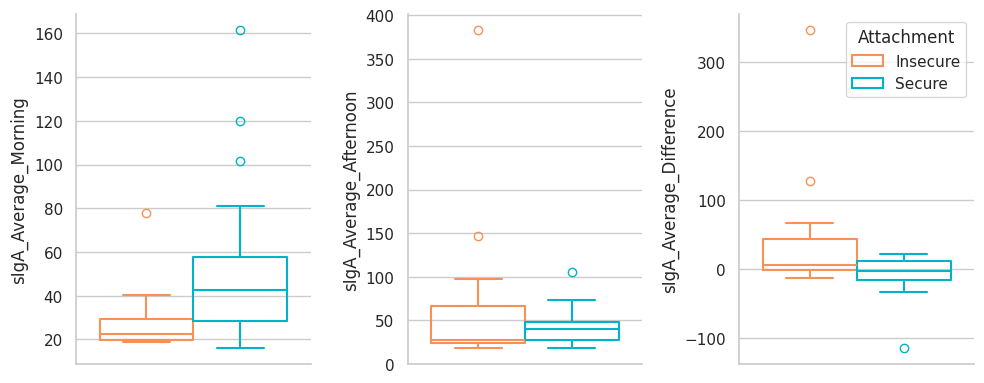

In [9]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Morning", 
    hue="Attachment", 
    ax=axes[0], 
    fill=False,
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Afternoon", 
    hue="Attachment", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Difference", 
    hue="Attachment", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

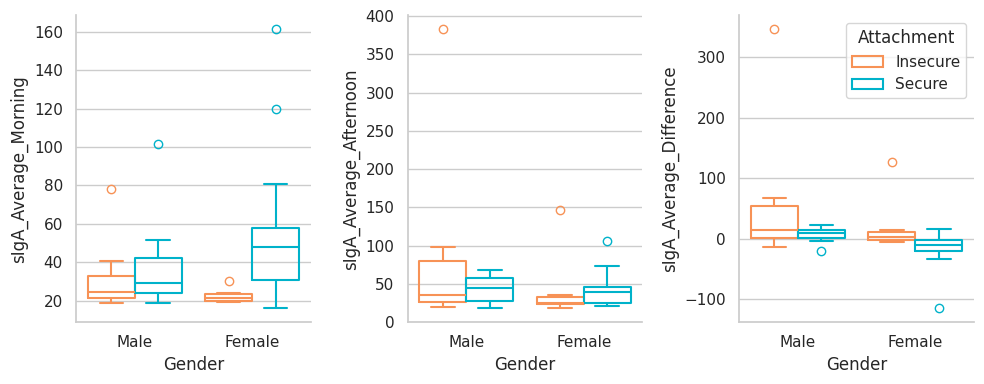

In [10]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Morning", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[0], 
    fill=False,
    palette=palette, 
    legend=False)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Afternoon", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Difference", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

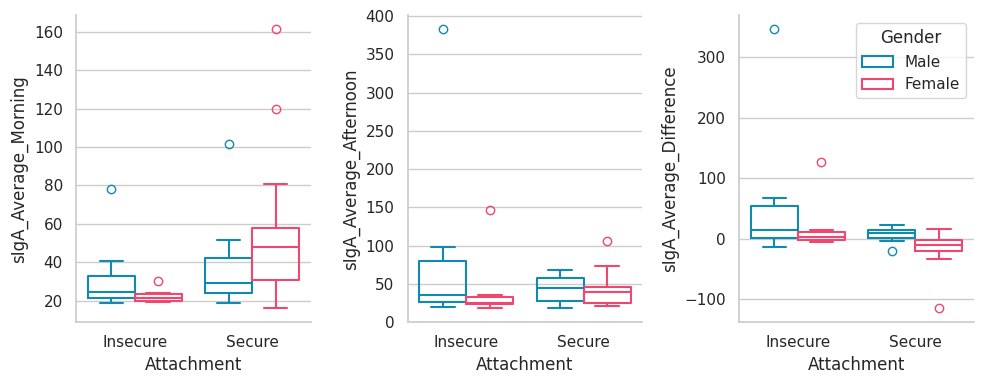

In [11]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Male": "#118AB2", "Female": "#EF476F"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Morning", 
    x="Attachment", 
    hue="Gender", 
    ax=axes[0], 
    fill=False,
    palette=palette, 
    legend=False)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Afternoon", 
    x="Attachment", 
    hue="Gender", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data, 
    y="sIgA_Average_Difference", 
    x="Attachment", 
    hue="Gender", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

- U-test and Kruskal comparison

In [12]:
iga_vars = ["sIgA_Average_Morning", "sIgA_Average_Afternoon", 
            "sIgA_Average_Difference"]

gender_results = []
for var in iga_vars:
    male_vals = df_data[df_data["Gender"] == "Male"][var]
    female_vals = df_data[df_data["Gender"] == "Female"][var]
    stat, p = mannwhitneyu(male_vals, female_vals, alternative='two-sided')
    statistic_result = {"variable": var, "U statistic": stat, "p-value": p}
    gender_results.append(statistic_result)

gender_results = pd.DataFrame(gender_results)
gender_results["reject"] = gender_results["p-value"]<=0.05
gender_results

,variable,U statistic,p-value,reject
0,sIgA_Average_Morning,118.0,0.293718,False
1,sIgA_Average_Afternoon,173.0,0.453255,False
2,sIgA_Average_Difference,215.0,0.031555,True


In [13]:
attachment_results = []
for var in iga_vars:
    secure_vals = df_data[df_data["Attachment"] == "Secure"][var]
    insecure_vals = df_data[df_data["Attachment"] == "Insecure"][var]
    stat, p = mannwhitneyu(secure_vals, insecure_vals, alternative='two-sided')
    statistic_result = {"variable": var, "U statistic": stat, "p-value": p}
    attachment_results.append(statistic_result)

attachment_results = pd.DataFrame(attachment_results)
attachment_results["reject"] = attachment_results["p-value"]<=0.05
attachment_results

,variable,U statistic,p-value,reject
0,sIgA_Average_Morning,220.0,0.014638,True
1,sIgA_Average_Afternoon,162.0,0.625380,False
2,sIgA_Average_Difference,83.0,0.032504,True


In [14]:
df_data["Group"] = df_data["Attachment"] + " - " + df_data["Gender"]

kruskal_results = {}
for var in iga_vars:
    data = [group[var].values for name, group in df_data.groupby("Group")]
    stat, p = kruskal(*data)
    kruskal_results[var] = {"H statistic": stat, "p-value": p}
kruskal_df = pd.DataFrame(kruskal_results).T

print("=== Kruskal–Wallis Results ===")
print(kruskal_df)

# Post-hoc Dunn test with Holm correction
print("\n=== Dunn's Test (Holm-corrected p-values) ===")
for var in iga_vars:
    print(f"\n--- {var} ---")
    posthoc = sp.posthoc_dunn(
        df_data,
        val_col=var,
        group_col="Group",
        p_adjust='holm'
    )
    print(posthoc)

=== Kruskal–Wallis Results ===
                         H statistic   p-value
sIgA_Average_Morning        8.605669  0.035020
sIgA_Average_Afternoon      1.504082  0.681329
sIgA_Average_Difference     8.210884  0.041849

=== Dunn's Test (Holm-corrected p-values) ===

--- sIgA_Average_Morning ---
                   Insecure - Female  Insecure - Male  Secure - Female  \
Insecure - Female           1.000000         0.815097         0.042203   
Insecure - Male             0.815097         1.000000         0.251066   
Secure - Female             0.042203         0.251066         1.000000   
Secure - Male               0.682348         0.815097         0.682348   

                   Secure - Male  
Insecure - Female       0.682348  
Insecure - Male         0.815097  
Secure - Female         0.682348  
Secure - Male           1.000000  

--- sIgA_Average_Afternoon ---
                   Insecure - Female  Insecure - Male  Secure - Female  \
Insecure - Female                1.0              1.

- Cliffs estimation

In [15]:
gender_cliffs = []
for var in iga_vars:
    male = df_data[df_data["Gender"] == "Male"][var]
    female = df_data[df_data["Gender"] == "Female"][var]
    delta, interp = cliffs_delta(male, female)
    gender_cliffs.append({"variable": var, "Cliff's Delta": delta, "Interpretation": interp})

gender_cliffs = pd.DataFrame(gender_cliffs)
gender_cliffs

,variable,Cliff's Delta,Interpretation
0,sIgA_Average_Morning,-0.213333,Small
1,sIgA_Average_Afternoon,0.153333,Small
2,sIgA_Average_Difference,0.433333,Medium


In [16]:
attachment_cliffs = []
for var in iga_vars:
    secure = df_data[df_data["Attachment"] == "Secure"][var]
    insecure = df_data[df_data["Attachment"] == "Insecure"][var]
    delta, interp = cliffs_delta(insecure, secure)
    attachment_cliffs.append({"variable": var, "Cliff's Delta": delta, "Interpretation": interp})

attachment_cliffs = pd.DataFrame(attachment_cliffs)
attachment_cliffs

,variable,Cliff's Delta,Interpretation
0,sIgA_Average_Morning,-0.496599,Large
1,sIgA_Average_Afternoon,-0.102041,Negligible
2,sIgA_Average_Difference,0.435374,Medium


In [17]:
combined_cliffs = {}
grouped = df_data.groupby(["Attachment", "Gender"])
groups = list(grouped.groups.keys())

if len(groups) >= 2:
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            label = f"{g1} vs {g2}"
            results = {}
            for var in iga_vars:
                data1 = grouped.get_group(g1)[var]
                data2 = grouped.get_group(g2)[var]
                if len(data1) > 0 and len(data2) > 0:
                    delta, interp = cliffs_delta(data1, data2)
                    results[var] = {"Cliff's Delta": delta, "Interpretation": interp}
            combined_cliffs[label] = results

combined_cliffs_df = pd.concat({k: pd.DataFrame(v).T for k, v in combined_cliffs.items()}, names=["Group Comparison", "Variable"])
combined_cliffs_df

Cliff's Delta  \
Group Comparison                               Variable                                
('Insecure', 'Female') vs ('Insecure', 'Male') sIgA_Average_Morning        -0.333333   
                                               sIgA_Average_Afternoon      -0.291667   
                                               sIgA_Average_Difference     -0.166667   
('Insecure', 'Female') vs ('Secure', 'Female') sIgA_Average_Morning        -0.761905   
                                               sIgA_Average_Afternoon      -0.309524   
                                               sIgA_Average_Difference      0.571429   
('Insecure', 'Female') vs ('Secure', 'Male')   sIgA_Average_Morning        -0.333333   
                                               sIgA_Average_Afternoon      -0.333333   
                                               sIgA_Average_Difference     -0.095238   
('Insecure', 'Male') vs ('Secure', 'Female')   sIgA_Average_Morning        -0.535714   
                                               sIgA_Average_Afternoon       0.071429   
                                               sIgA_Average_Difference      0.642857   
('Insecure', 'Male') vs ('Secure', 'Male')     sIgA_Average_Morning        -0.142857   
                                               sIgA_Average_Afternoon       0.035714   
                                               sIgA_Average_Difference      0.214286   
('Secure', 'Female') vs ('Secure', 'Male')     sIgA_Average_Morning         0.346939   
                                               sIgA_Average_Afternoon      -0.102041   
                                               sIgA_Average_Difference     -0.469388   

                                                                       Interpretation  
Group Comparison                               Variable                                
('Insecure', 'Female') vs ('Insecure', 'Male') sIgA_Average_Morning            Medium  
                                               sIgA_Average_Afternoon           Small  
                                               sIgA_Average_Difference          Small  
('Insecure', 'Female') vs ('Secure', 'Female') sIgA_Average_Morning             Large  
                                               sIgA_Average_Afternoon           Small  
                                               sIgA_Average_Difference          Large  
('Insecure', 'Female') vs ('Secure', 'Male')   sIgA_Average_Morning            Medium  
                                               sIgA_Average_Afternoon          Medium  
                                               sIgA_Average_Difference     Negligible  
('Insecure', 'Male') vs ('Secure', 'Female')   sIgA_Average_Morning             Large  
                                               sIgA_Average_Afternoon      Negligible  
                                               sIgA_Average_Difference          Large  
('Insecure', 'Male') vs ('Secure', 'Male')     sIgA_Average_Morning        Negligible  
                                               sIgA_Average_Afternoon      Negligible  
                                               sIgA_Average_Difference          Small  
('Secure', 'Female') vs ('Secure', 'Male')     sIgA_Average_Morning            Medium  
                                               sIgA_Average_Afternoon      Negligible  
                                               sIgA_Average_Difference         Medium

- RBC estimation 

In [18]:
rbc_gender = []
for var in iga_vars:
    male = df_data[df_data["Gender"] == "Male"][var]
    female = df_data[df_data["Gender"] == "Female"][var]
    rbc, interp = rank_biserial_correlation(male, female)
    rbc_gender.append({"variable": var, "Rank-Biserial Corr": rbc, "Interpretation": interp})
rbc_gender = pd.DataFrame(rbc_gender)
rbc_gender

,variable,Rank-Biserial Corr,Interpretation
0,sIgA_Average_Morning,0.213333,Small
1,sIgA_Average_Afternoon,-0.153333,Small
2,sIgA_Average_Difference,-0.433333,Medium


In [19]:
rbc_attachment = []
for var in iga_vars:
    secure = df_data[df_data["Attachment"] == "Secure"][var]
    insecure = df_data[df_data["Attachment"] == "Insecure"][var]
    rbc, interp = rank_biserial_correlation(secure, insecure)
    rbc_attachment.append({"variable": var, "Rank-Biserial Corr": rbc, "Interpretation": interp})
rbc_attachment = pd.DataFrame(rbc_attachment)
rbc_attachment

,variable,Rank-Biserial Corr,Interpretation
0,sIgA_Average_Morning,-0.496599,Medium
1,sIgA_Average_Afternoon,-0.102041,Small
2,sIgA_Average_Difference,0.435374,Medium


- Merge all comparisons

In [20]:
rbc_combined = {}
grouped = df_data.groupby(["Attachment", "Gender"])
groups = list(grouped.groups.keys())

if len(groups) >= 2:
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            label = f"{g1} vs {g2}"
            results = {}
            for var in iga_vars:
                data1 = grouped.get_group(g1)[var]
                data2 = grouped.get_group(g2)[var]
                if len(data1) > 0 and len(data2) > 0:
                    rbc, interp = rank_biserial_correlation(data1, data2)
                    results[var] = {"Rank-Biserial Corr": rbc, "Interpretation": interp}
            rbc_combined[label] = results

rbc_combined_df = pd.concat({k: pd.DataFrame(v).T for k, v in rbc_combined.items()}, names=["Group Comparison", "Variable"])
rbc_combined_df

Rank-Biserial Corr  \
Group Comparison                               Variable                                     
('Insecure', 'Female') vs ('Insecure', 'Male') sIgA_Average_Morning              0.333333   
                                               sIgA_Average_Afternoon            0.291667   
                                               sIgA_Average_Difference           0.166667   
('Insecure', 'Female') vs ('Secure', 'Female') sIgA_Average_Morning              0.761905   
                                               sIgA_Average_Afternoon            0.309524   
                                               sIgA_Average_Difference          -0.571429   
('Insecure', 'Female') vs ('Secure', 'Male')   sIgA_Average_Morning              0.333333   
                                               sIgA_Average_Afternoon            0.333333   
                                               sIgA_Average_Difference           0.095238   
('Insecure', 'Male') vs ('Secure', 'Female')   sIgA_Average_Morning              0.535714   
                                               sIgA_Average_Afternoon           -0.071429   
                                               sIgA_Average_Difference          -0.642857   
('Insecure', 'Male') vs ('Secure', 'Male')     sIgA_Average_Morning              0.142857   
                                               sIgA_Average_Afternoon           -0.035714   
                                               sIgA_Average_Difference          -0.214286   
('Secure', 'Female') vs ('Secure', 'Male')     sIgA_Average_Morning             -0.346939   
                                               sIgA_Average_Afternoon            0.102041   
                                               sIgA_Average_Difference           0.469388   

                                                                       Interpretation  
Group Comparison                               Variable                                
('Insecure', 'Female') vs ('Insecure', 'Male') sIgA_Average_Morning            Medium  
                                               sIgA_Average_Afternoon           Small  
                                               sIgA_Average_Difference          Small  
('Insecure', 'Female') vs ('Secure', 'Female') sIgA_Average_Morning             Large  
                                               sIgA_Average_Afternoon          Medium  
                                               sIgA_Average_Difference          Large  
('Insecure', 'Female') vs ('Secure', 'Male')   sIgA_Average_Morning            Medium  
                                               sIgA_Average_Afternoon          Medium  
                                               sIgA_Average_Difference     Negligible  
('Insecure', 'Male') vs ('Secure', 'Female')   sIgA_Average_Morning             Large  
                                               sIgA_Average_Afternoon      Negligible  
                                               sIgA_Average_Difference          Large  
('Insecure', 'Male') vs ('Secure', 'Male')     sIgA_Average_Morning             Small  
                                               sIgA_Average_Afternoon      Negligible  
                                               sIgA_Average_Difference          Small  
('Secure', 'Female') vs ('Secure', 'Male')     sIgA_Average_Morning            Medium  
                                               sIgA_Average_Afternoon           Small  
                                               sIgA_Average_Difference         Medium

- Merge comparisons

In [21]:
gender_results.merge(right=gender_cliffs, on="variable").merge(right=rbc_gender, on="variable")

,variable,U statistic,p-value,reject,Cliff's Delta,Interpretation_x,Rank-Biserial Corr,Interpretation_y
0,sIgA_Average_Morning,118.0,0.293718,False,-0.213333,Small,0.213333,Small
1,sIgA_Average_Afternoon,173.0,0.453255,False,0.153333,Small,-0.153333,Small
2,sIgA_Average_Difference,215.0,0.031555,True,0.433333,Medium,-0.433333,Medium


In [22]:
attachment_results.merge(right=attachment_cliffs, on="variable").merge(right=rbc_attachment, on="variable")

,variable,U statistic,p-value,reject,Cliff's Delta,Interpretation_x,Rank-Biserial Corr,Interpretation_y
0,sIgA_Average_Morning,220.0,0.014638,True,-0.496599,Large,-0.496599,Medium
1,sIgA_Average_Afternoon,162.0,0.625380,False,-0.102041,Negligible,-0.102041,Small
2,sIgA_Average_Difference,83.0,0.032504,True,0.435374,Medium,0.435374,Medium


- Data visualization with multiple plots

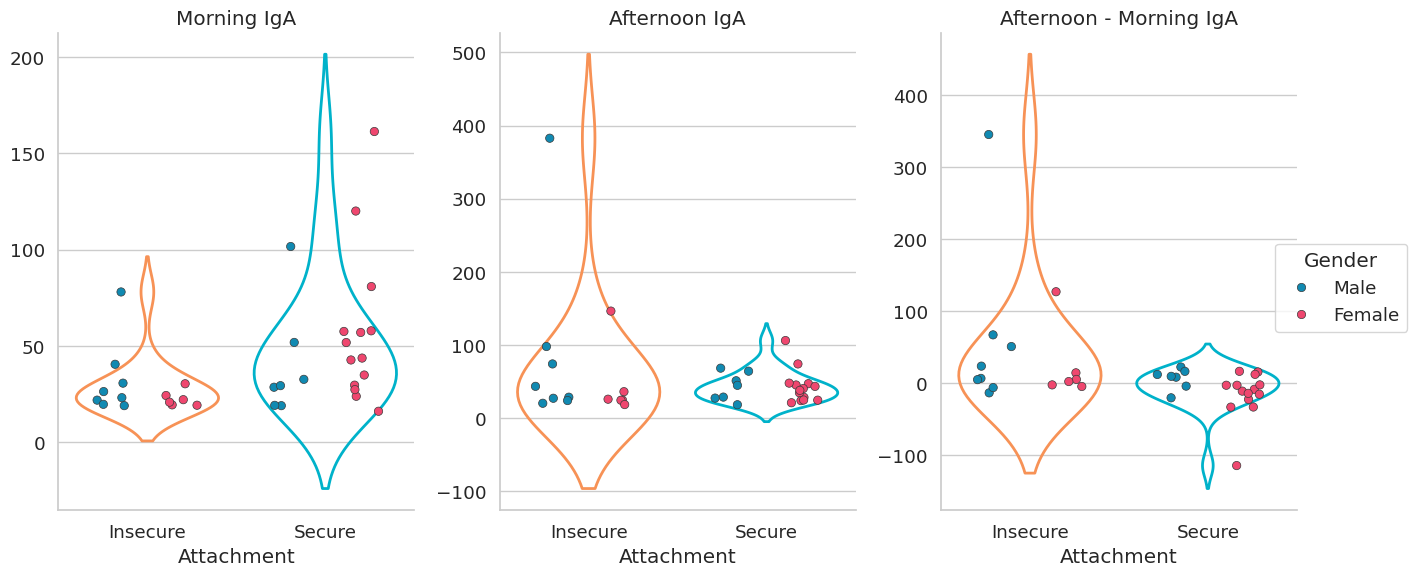

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=True)
sns.set(style="whitegrid", font_scale=1.2)


titles = [
    "Morning IgA",
    "Afternoon IgA",
    "Afternoon - Morning IgA"
]

for ax, var, title in zip(axes, iga_vars, titles):
    # Violin plot
    sns.violinplot(
        data=df_data,
        x="Attachment",
        y=var,
        inner=None,
        palette={"Secure": "#00B2CA", "Insecure": "#F79256"},
        linewidth=2,
        fill=False,
        ax=ax
    )

    # Stripplot (jitter individual points)
    sns.stripplot(
        data=df_data,
        x="Attachment",
        y=var,
        hue="Gender",
        dodge=True,
        jitter=0.2,
        size=6,
        palette={"Male": "#118AB2", "Female": "#EF476F"},
        linewidth=0.5,
        edgecolor="gray",
        ax=ax
    )

    ax.set_title(title)
    ax.set_xlabel("Attachment")
    ax.set_ylabel("")
    ax.legend_.remove()

# Añadir leyenda común
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Gender", loc='center right', bbox_to_anchor=(1.02, 0.5))
sns.despine()
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

- Working with clustering and pattern recognition for profile generation. Manually with the following ranges:

| Range  | Category        | Justification                                                                                                       |
| ------ | -------------------- | ------------------------------------------------------------------------------------------------------------------- |
| `> 50` | **High variability** | It represents a significant change in daily concentration (>50 µg/mL), beyond the typical circadian variation. |
| `≤ 50` | **Low/Moderate**     | Changes that could be physiological, within the range expected under normal conditions.                           |


| Range    | Category    | Justification                                                                                                         |
| -------- | ---------------- | --------------------------------------------------------------------------------------------------------------------- |
| `< 30`   | **Low IgA**      | Consistently low values ​​in the sample possibly reflect immune suppression or specific conditions. |
| `30–100` | **Moderate IgA** | Central range of most subjects.                                                                           |
| `> 100`  | **High IgA**     | Less frequent elevated values ​​that could be biologically or clinically significant.                     |


In [26]:
df_data["Variability_Profile"] = df_data["sIgA_Average_Difference"].apply(
    lambda x: "High variability" if x > 50 else "Low/Moderate"
)

df_data["sIgA_Level_Profile_Morning"] = df_data["sIgA_Average_Morning"].apply(classify_iga_level)
df_data["sIgA_Level_Profile_Afternoon"] = df_data["sIgA_Average_Afternoon"].apply(classify_iga_level)
df_data.head(5)


,ID,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment,Group,Variability_Profile,sIgA_Level_Profile_Morning,sIgA_Level_Profile_Afternoon
0,1,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure,Insecure - Male,Low/Moderate,Low sIgA,Low sIgA
1,4,Male,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure,Secure - Male,Low/Moderate,Low sIgA,Moderate sIgA
2,5,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure,Secure - Female,Low/Moderate,High sIgA,Moderate sIgA
3,7,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure,Insecure - Female,Low/Moderate,Low sIgA,Moderate sIgA
4,12,Female,29.554870,45.078186,15.523316,3.368950,3.587869,0.218919,Secure,Secure - Female,Low/Moderate,Low sIgA,Moderate sIgA


In [27]:
df_data["Variability_Profile"].value_counts()

Variability_Profile
Low/Moderate        31
High variability     4
Name: count, dtype: int64

In [28]:
df_data["sIgA_Level_Profile_Morning"].value_counts()

sIgA_Level_Profile_Morning
Low sIgA         18
Moderate sIgA    14
High sIgA         3
Name: count, dtype: int64

In [29]:
df_data["sIgA_Level_Profile_Afternoon"].value_counts()

sIgA_Level_Profile_Afternoon
Low sIgA         16
Moderate sIgA    16
High sIgA         3
Name: count, dtype: int64

- Checking changes

In [30]:
changing_data = []
for index in df_data.index:
    change = ""
    morning = df_data["sIgA_Level_Profile_Morning"][index]
    afternoon = df_data["sIgA_Level_Profile_Afternoon"][index]

    if morning == afternoon:
        change = "No Change"
    elif (morning == "Low sIgA" and afternoon in ["Moderate sIgA", "High sIgA"]) or (morning == "Moderate sIgA" and afternoon == "High sIgA"):
        change = "Increase"
    elif (morning == "Moderate sIgA" and afternoon == "Low sIgA") or (morning == "High sIgA" and afternoon == "Moderate sIgA"):
        change = "Decrease"
    else:
        change = "check"
    
    changing_data.append(change)

df_data["sIgA-Change"] = changing_data
df_data["sIgA-Change"].value_counts()
    

sIgA-Change
No Change    22
Increase      7
Decrease      6
Name: count, dtype: int64

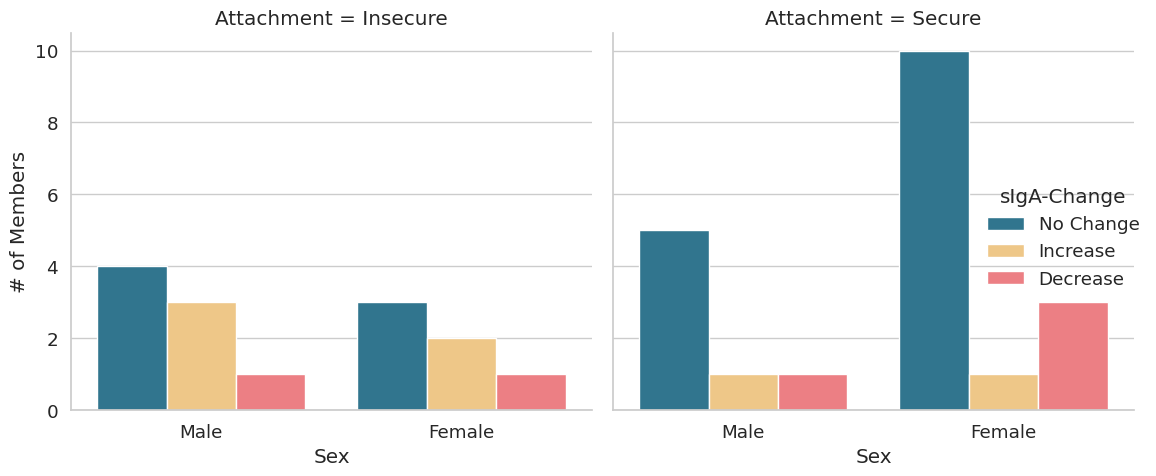

In [31]:
g = sns.catplot(
    data=df_data,
    kind="count",
    x="Gender",
    hue="sIgA-Change",
    col="Attachment",
    palette=["#227C9D", "#FFCB77", "#FE6D73"]
)

g.set_axis_labels("Sex", "# of Members")
g._legend.set_title("sIgA-Change")
plt.tight_layout()
plt.show()


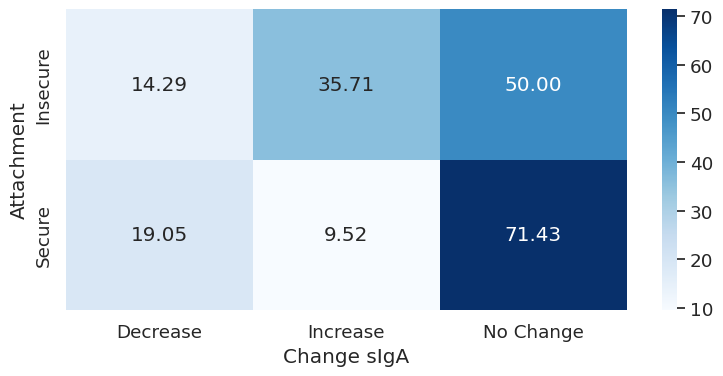

In [32]:
heat_data = pd.crosstab(df_data["Attachment"], df_data["sIgA-Change"], normalize='index')*100

plt.figure(figsize=(8, 4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
plt.ylabel("Attachment")
plt.xlabel("Change sIgA")
plt.tight_layout()
plt.show()

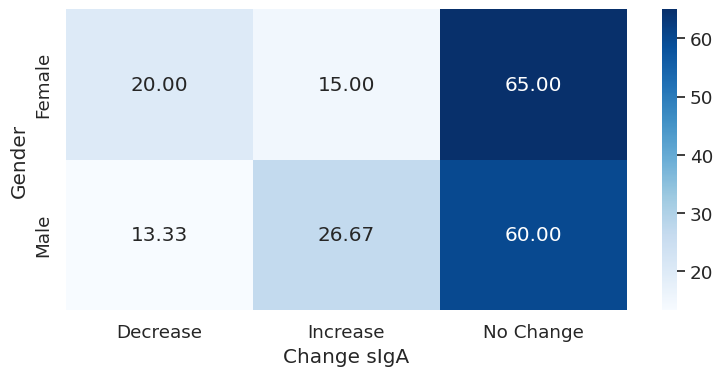

In [33]:
heat_data = pd.crosstab(df_data["Gender"], df_data["sIgA-Change"], normalize='index')*100

plt.figure(figsize=(8, 4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
plt.ylabel("Gender")
plt.xlabel("Change sIgA")
plt.tight_layout()
plt.show()

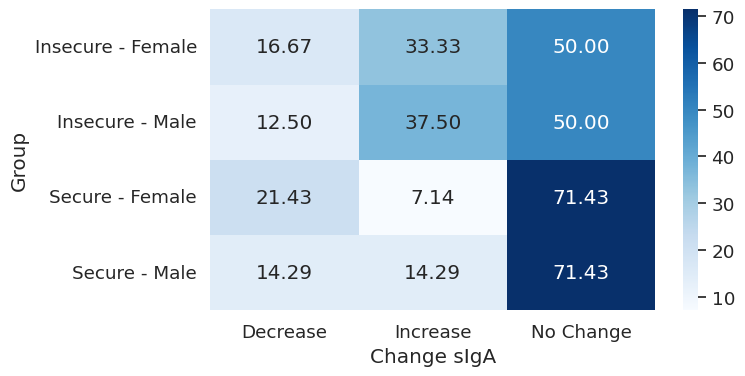

In [34]:
heat_data = pd.crosstab(df_data["Group"], df_data["sIgA-Change"], normalize='index')*100

plt.figure(figsize=(8, 4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
plt.ylabel("Group")
plt.xlabel("Change sIgA")
plt.tight_layout()
plt.show()

### Additional analysis (1): PCA visualization and scatter plots

In [35]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [36]:
df_data.columns

Index(['ID', 'Gender', 'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'sIgA_Average_Morning_log',
       'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log',
       'Attachment', 'Group', 'Variability_Profile',
       'sIgA_Level_Profile_Morning', 'sIgA_Level_Profile_Afternoon',
       'sIgA-Change'],
      dtype='object')

In [37]:
df_for_reductions = df_data[iga_vars]
df_for_reductions.head()

,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference
0,21.765240,28.368055,6.602815
1,28.473065,50.881961,22.408896
2,161.424693,46.867951,-114.556742
3,24.173487,35.942378,14.343241
4,29.554870,45.078186,15.523316


In [38]:
pca_instance = PCA()
pca_instance.fit(X=df_for_reductions.values)
header = [f"p_{i+1}" for i in range(pca_instance.n_components_)]
data_transformed = pd.DataFrame(
    data=pca_instance.transform(df_for_reductions.values),
    columns=header,
    index=df_data.index)
print(pca_instance.n_components_)
print(pca_instance.explained_variance_ratio_)
data_transformed.head(5)

3
[8.45888493e-01 1.53448346e-01 6.63160426e-04]


,p_1,p_2,p_3
0,-22.048852,-24.489125,-0.483245
1,5.008492,-16.241188,0.771640
2,-94.963863,146.416001,0.735943
3,-11.174119,-22.541833,-1.499330
4,-3.960300,-14.928185,0.452088


In [39]:
data_transformed = pd.concat([data_transformed, df_data], axis=1)
data_transformed.head(5)

,p_1,p_2,p_3,ID,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment,Group,Variability_Profile,sIgA_Level_Profile_Morning,sIgA_Level_Profile_Afternoon,sIgA-Change
0,-22.048852,-24.489125,-0.483245,1,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure,Insecure - Male,Low/Moderate,Low sIgA,Low sIgA,No Change
1,5.008492,-16.241188,0.771640,4,Male,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure,Secure - Male,Low/Moderate,Low sIgA,Moderate sIgA,Increase
2,-94.963863,146.416001,0.735943,5,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure,Secure - Female,Low/Moderate,High sIgA,Moderate sIgA,Decrease
3,-11.174119,-22.541833,-1.499330,7,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure,Insecure - Female,Low/Moderate,Low sIgA,Moderate sIgA,Increase
4,-3.960300,-14.928185,0.452088,12,Female,29.554870,45.078186,15.523316,3.368950,3.587869,0.218919,Secure,Secure - Female,Low/Moderate,Low sIgA,Moderate sIgA,Increase


In [40]:
tsne_instance = TSNE(n_components=2, perplexity=3)
header = ["p_1", "p_2"]
tsne_data_transformed = pd.DataFrame(
    data=tsne_instance.fit_transform(df_for_reductions.values),
    columns=header,
    index=df_data.index)
tsne_data_transformed.head(5)

,p_1,p_2
0,-40.038315,-103.254570
1,-18.327919,-40.559719
2,-25.907005,123.936455
3,-19.642025,-75.309265
4,-9.900530,-51.558651


In [41]:
tsne_data_transformed = pd.concat([tsne_data_transformed, df_data], axis=1)
tsne_data_transformed.head(5)

,p_1,p_2,ID,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment,Group,Variability_Profile,sIgA_Level_Profile_Morning,sIgA_Level_Profile_Afternoon,sIgA-Change
0,-40.038315,-103.254570,1,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure,Insecure - Male,Low/Moderate,Low sIgA,Low sIgA,No Change
1,-18.327919,-40.559719,4,Male,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure,Secure - Male,Low/Moderate,Low sIgA,Moderate sIgA,Increase
2,-25.907005,123.936455,5,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure,Secure - Female,Low/Moderate,High sIgA,Moderate sIgA,Decrease
3,-19.642025,-75.309265,7,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure,Insecure - Female,Low/Moderate,Low sIgA,Moderate sIgA,Increase
4,-9.900530,-51.558651,12,Female,29.554870,45.078186,15.523316,3.368950,3.587869,0.218919,Secure,Secure - Female,Low/Moderate,Low sIgA,Moderate sIgA,Increase


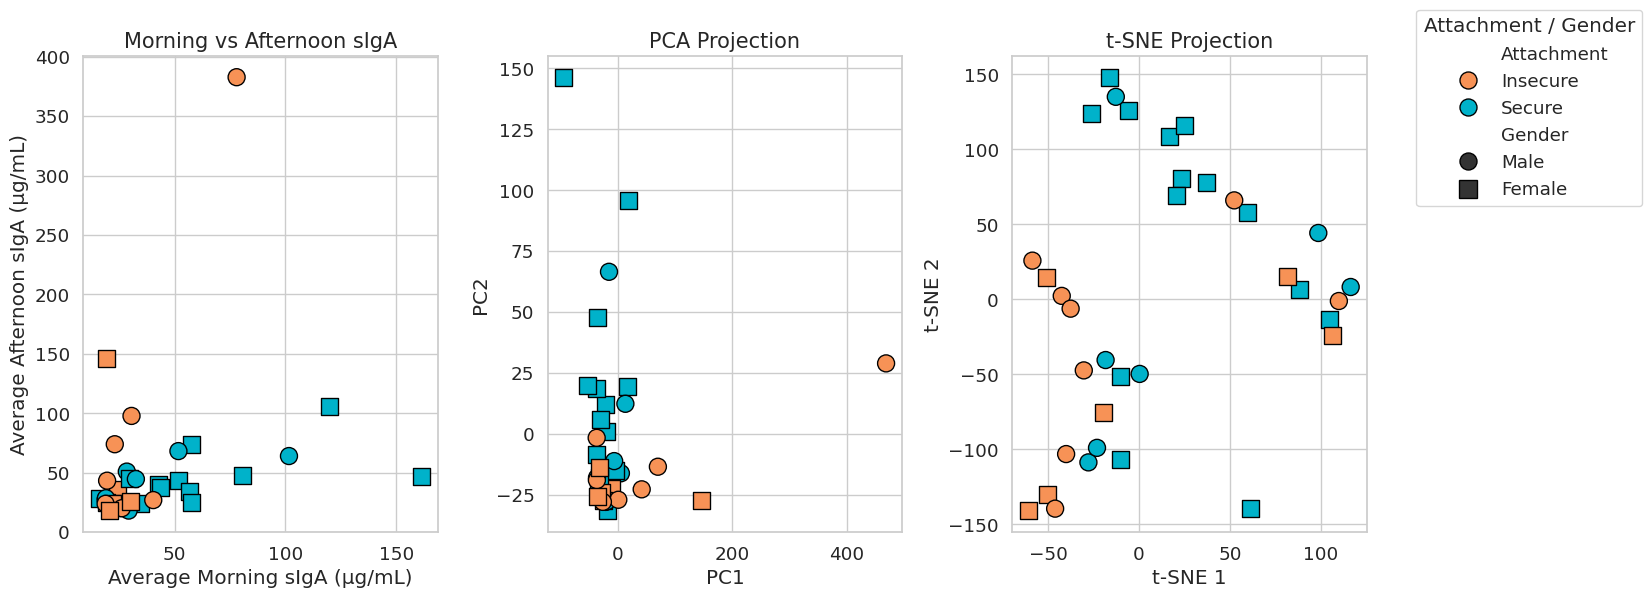

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=False)
sns.set(style="whitegrid", font_scale=1.2)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256", "Unknown": "#58E0B0"}
markers = {"Male": "o", "Female": "s"}

# Gráfico 1: Promedio IgA Mañana vs Tarde
sns.scatterplot(
    ax=axes[0],
    data=df_data,
    x="sIgA_Average_Morning",
    y="sIgA_Average_Afternoon",
    hue="Attachment",
    style="Gender",
    palette=palette,
    markers=markers,
    s=150,
    edgecolor="black",
)

axes[0].set_title("Morning vs Afternoon sIgA", fontsize=15)
axes[0].set_xlabel("Average Morning sIgA (µg/mL)")
axes[0].set_ylabel("Average Afternoon sIgA (µg/mL)")

# Gráfico 2: Proyección PCA
sns.scatterplot(
    ax=axes[1],
    data=data_transformed,
    x="p_1",
    y="p_2",
    hue="Attachment",
    style="Gender",
    palette=palette,
    markers=markers,
    s=150,
    edgecolor="black"
)

axes[1].set_title("PCA Projection", fontsize=15)
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

# Gráfico 3: Proyección t-SNE
sns.scatterplot(
    ax=axes[2],
    data=tsne_data_transformed,
    x="p_1",
    y="p_2",
    hue="Attachment",
    style="Gender",
    palette=palette,
    markers=markers,
    s=150,
    edgecolor="black"
)
axes[2].set_title("t-SNE Projection", fontsize=15)
axes[2].set_xlabel("t-SNE 1")
axes[2].set_ylabel("t-SNE 2")

handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, title="Attachment / Gender", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

for ax in axes:
    ax.get_legend().remove()

plt.tight_layout()

### Additional analysis (2): Bayesian analysis

Based on the dataset, we can define a **Bayesian logistic regression model** that uses the **IgA-related variables** to estimate the probability of an individual being classified as **insecurely attached**. This approach is conceptually aligned with your previous findings and avoids potential confounds from hormonal measures like cortisol.


### **Bayesian Model Specification**

Let $y_i \in \{0, 1\}$ be the binary attachment label for individual $i$, where 1 = insecure, and 0 = secure.

We model the probability $p_i$ of insecure attachment via a logistic function:

$$
y_i \sim \text{Bernoulli}(p_i)
$$

$$
\text{logit}(p_i) = \alpha + \beta_1 \cdot \text{IgA}_{\text{morning}, i} + \beta_2 \cdot \text{IgA}_{\text{afternoon}, i} + \beta_3 \cdot \text{IgA}_{\text{difference}, i}
$$

Where:

* $\alpha \sim \mathcal{N}(0, 2)$ is the intercept,
* $\beta_j \sim \mathcal{N}(0, 2)$ are priors for the IgA coefficients.

In [43]:
import pymc as pm
import arviz as az

# Encode attachment
df_data['Attachment_binary'] = df_data['Attachment'].map({'Secure': 0, 'Insecure': 1})

# Select predictors
X = df_data[['sIgA_Average_Morning', 'sIgA_Average_Afternoon', 'sIgA_Average_Difference']]
y = df_data['Attachment_binary'].values

# Normalize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
iga_morning = X_scaled[:, 0]
iga_afternoon = X_scaled[:, 1]
iga_diff = X_scaled[:, 2]

# Define Bayesian logistic regression model
with pm.Model() as iga_model:
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta_morning = pm.Normal("beta_siga_morning", mu=0, sigma=2)
    beta_afternoon = pm.Normal("beta_siga_afternoon", mu=0, sigma=2)
    beta_diff = pm.Normal("beta_siga_diff", mu=0, sigma=2)

    # Linear predictor
    mu = (alpha +
          beta_morning * iga_morning +
          beta_afternoon * iga_afternoon +
          beta_diff * iga_diff)

    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y)

    # Posterior sampling
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=1,
        init="adapt_diag",
        target_accept=0.9,
        return_inferencedata=True
    )

# Posterior summary
az.summary(trace, hdi_prob=0.94)

Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_siga_morning, beta_siga_afternoon, beta_siga_diff]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.901,0.573,-1.966,0.170,0.021,0.015,810.0,738.0,1.00
beta_siga_morning,-2.195,1.078,-4.141,-0.159,0.037,0.025,865.0,851.0,1.00
beta_siga_afternoon,0.427,1.463,-2.095,3.492,0.052,0.041,784.0,869.0,1.01
beta_siga_diff,1.658,1.473,-1.222,4.291,0.052,0.037,800.0,1013.0,1.00
theta[0],0.546,0.113,0.341,0.756,0.002,0.002,2448.0,1584.0,1.00
theta[1],0.565,0.108,0.365,0.767,0.003,0.002,1412.0,1264.0,1.00
theta[2],0.002,0.016,0.000,0.002,0.000,0.005,951.0,878.0,1.00
theta[3],0.565,0.105,0.359,0.751,0.002,0.002,2201.0,1423.0,1.00
theta[4],0.498,0.102,0.317,0.695,0.003,0.002,1397.0,1375.0,1.00
theta[5],0.127,0.084,0.009,0.283,0.003,0.002,818.0,720.0,1.00


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

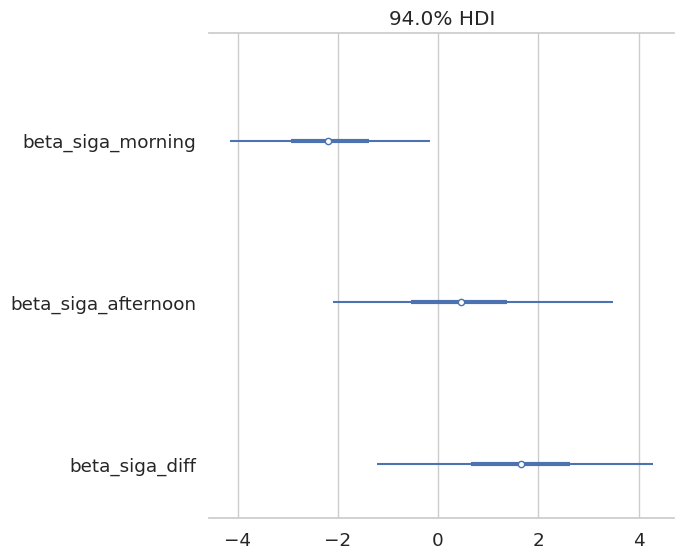

In [44]:
az.plot_forest(trace, var_names=["beta_siga_morning", "beta_siga_afternoon", "beta_siga_diff"], combined=True)

In [45]:
df_data.to_csv("../processed_data/6_processed_data_iga_analyzed_with_predictions.csv", index=False)

In [46]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans

In [47]:
dbscan_instance = DBSCAN()
dbscan_instance.fit(X=df_for_reductions)
dbscan_instance.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1])

In [48]:
agglomerative_instance = AgglomerativeClustering(n_clusters=2)
agglomerative_instance.fit(X=df_for_reductions)
agglomerative_instance.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [50]:
kmeans_instance_with_pca = KMeans(n_clusters=2, random_state=42)
kmeans_instance_with_pca.fit(pca_instance.transform(df_for_reductions.values))
kmeans_instance_with_pca.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [51]:
kmeans_instance_with_tsne = KMeans(n_clusters=4, random_state=42)
kmeans_instance_with_tsne.fit(tsne_data_transformed[["p_1", "p_2"]].values)
kmeans_instance_with_tsne.labels_

array([1, 2, 0, 1, 2, 0, 1, 1, 0, 3, 0, 0, 1, 0, 0, 1, 2, 0, 3, 1, 3, 2,
       3, 2, 1, 3, 3, 2, 2, 0, 1, 3, 0, 2, 0], dtype=int32)

In [52]:
df_kmeans_pca = pd.DataFrame(
    data=pca_instance.transform(df_for_reductions.values), 
    columns=["p1", "p2", "p3"],
    index=df_data.index)
df_kmeans_pca["label"] = kmeans_instance_with_pca.labels_

df_kmeans_tsne = pd.DataFrame(
    data=tsne_data_transformed[["p_1", "p_2"]].values, 
    columns=["p1", "p2"],
    index=df_data.index)
df_kmeans_tsne["label"] = kmeans_instance_with_tsne.labels_

df_kmeans_pca = pd.concat([df_kmeans_pca, df_data], axis=1)
df_kmeans_tsne = pd.concat([df_kmeans_tsne, df_data], axis=1)

In [53]:
df_kmeans_pca["label"] = df_kmeans_pca["label"].astype(str)
df_kmeans_tsne["label"] = df_kmeans_tsne["label"].astype(str)

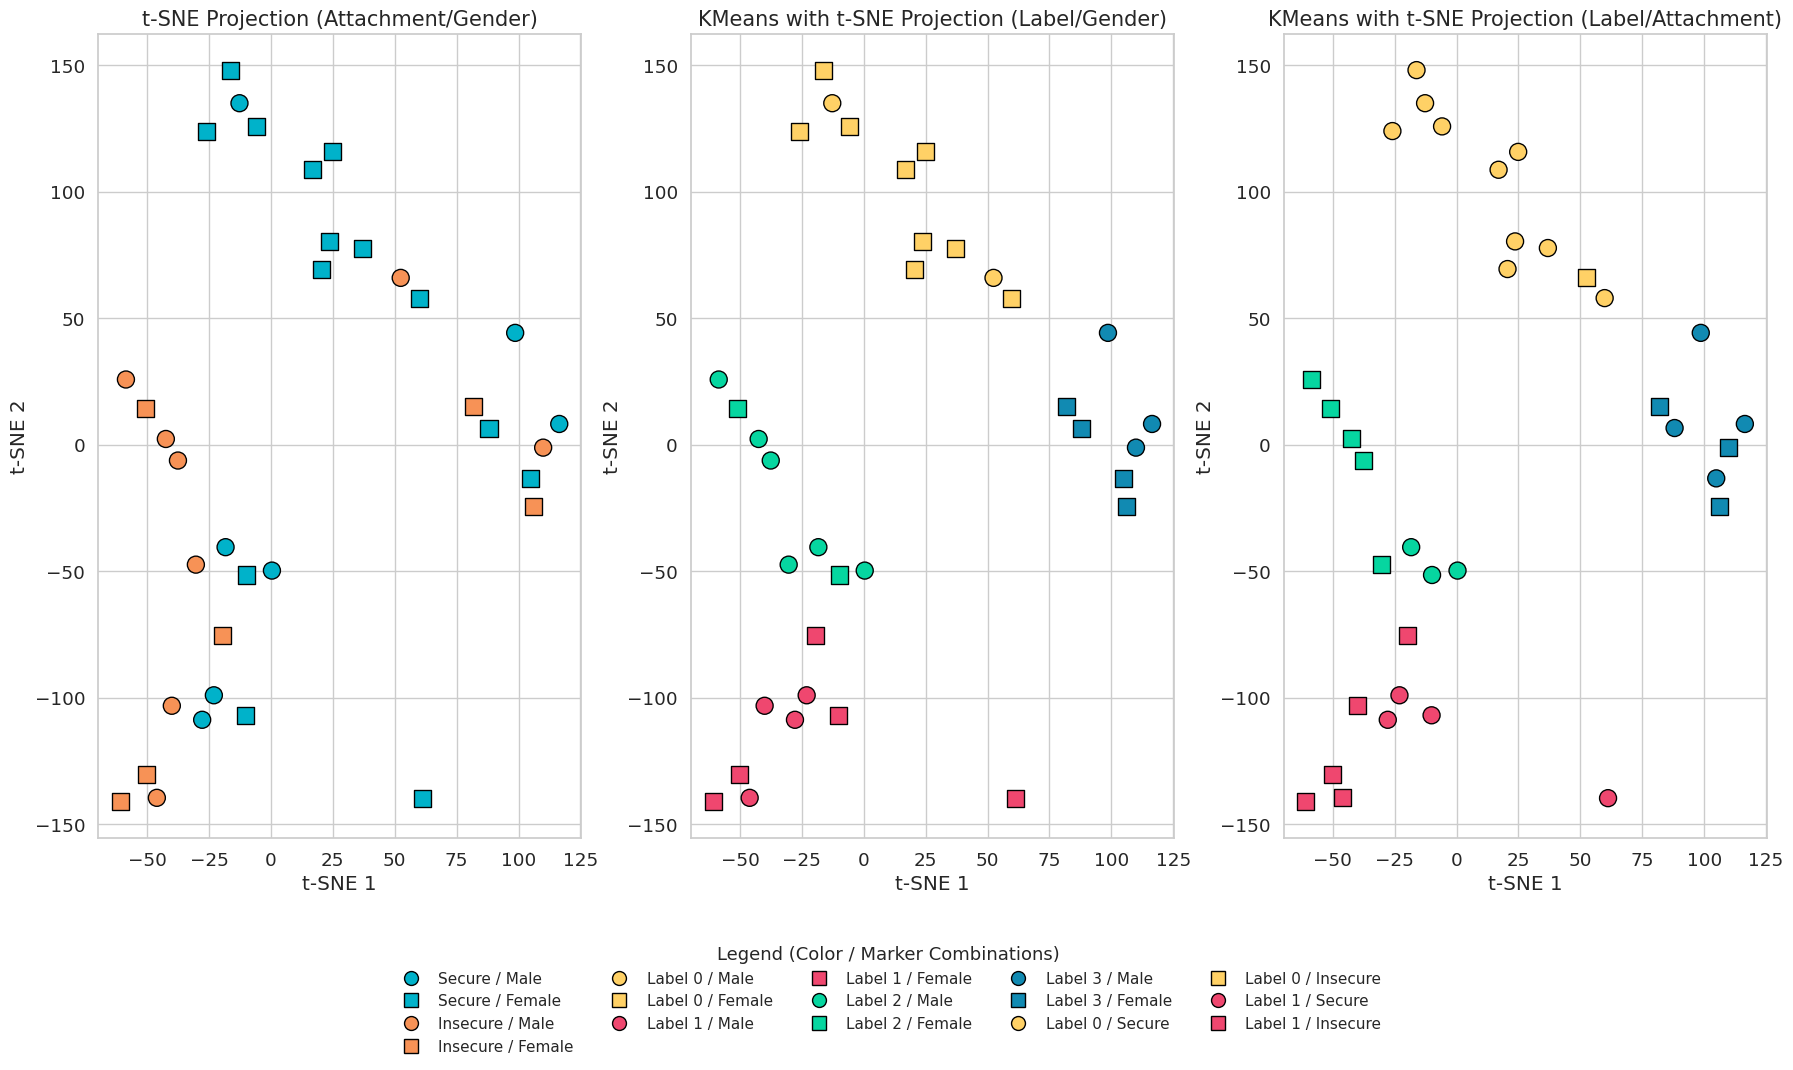

In [55]:
sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharex=False)

palette_labels = {"1": "#EF476F", "0": "#FFD166", "2": "#06D6A0", "3": "#118AB2"}
palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}
markers = {"Male": "o", "Female": "s"}
markers_attachment = {"Secure": "o", "Insecure": "s"}

legend_plot = sns.scatterplot(
    ax=axes[0],
    data=tsne_data_transformed,
    x="p_1",
    y="p_2",
    hue="Attachment",
    style="Gender",
    palette=palette,
    markers=markers,
    s=150,
    edgecolor="black"
)
axes[0].set_title("t-SNE Projection (Attachment/Gender)", fontsize=15)
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

sns.scatterplot(
    ax=axes[1],
    data=df_kmeans_tsne,
    x="p1",
    y="p2",
    hue="label",
    style="Gender",
    palette=palette_labels,
    markers=markers,
    s=150,
    edgecolor="black"
)
axes[1].set_title("KMeans with t-SNE Projection (Label/Gender)", fontsize=15)
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

sns.scatterplot(
    ax=axes[2],
    data=df_kmeans_tsne,
    x="p1",
    y="p2",
    hue="label",
    style="Attachment",
    palette=palette_labels,
    markers=markers_attachment,
    s=150,
    edgecolor="black"
)
axes[2].set_title("KMeans with t-SNE Projection (Label/Attachment)", fontsize=15)
axes[2].set_xlabel("t-SNE 1")
axes[2].set_ylabel("t-SNE 2")

handles, labels = legend_plot.get_legend_handles_labels()

for ax in axes.flat:
    ax.get_legend().remove()

legend_elements = [
    # Attachment + Gender
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette["Secure"],
           markeredgecolor='black', markersize=10, label='Secure / Male'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette["Secure"],
           markeredgecolor='black', markersize=10, label='Secure / Female'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette["Insecure"],
           markeredgecolor='black', markersize=10, label='Insecure / Male'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette["Insecure"],
           markeredgecolor='black', markersize=10, label='Insecure / Female'),

    # Cluster Label + Gender
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_labels["0"],
           markeredgecolor='black', markersize=10, label='Label 0 / Male'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette_labels["0"],
           markeredgecolor='black', markersize=10, label='Label 0 / Female'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_labels["1"],
           markeredgecolor='black', markersize=10, label='Label 1 / Male'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette_labels["1"],
           markeredgecolor='black', markersize=10, label='Label 1 / Female'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_labels["2"],
           markeredgecolor='black', markersize=10, label='Label 2 / Male'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette_labels["2"],
           markeredgecolor='black', markersize=10, label='Label 2 / Female'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_labels["3"],
           markeredgecolor='black', markersize=10, label='Label 3 / Male'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette_labels["3"],
           markeredgecolor='black', markersize=10, label='Label 3 / Female'),

    # Cluster Label + Attachment
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_labels["0"],
           markeredgecolor='black', markersize=10, label='Label 0 / Secure'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette_labels["0"],
           markeredgecolor='black', markersize=10, label='Label 0 / Insecure'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_labels["1"],
           markeredgecolor='black', markersize=10, label='Label 1 / Secure'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette_labels["1"],
           markeredgecolor='black', markersize=10, label='Label 1 / Insecure'),
]

# Añadir la leyenda combinada
fig.legend(
    handles=legend_elements,
    title="Legend (Color / Marker Combinations)",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),
    ncol=5,
    frameon=False,
    fontsize=11,
    title_fontsize=13
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.show()